In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import torch
from tqdm import tqdm

import numpy as np

In [2]:
trainset = MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=ToTensor()) # Download and load the train data
testset = MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=ToTensor()) # Download and load the test data

trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

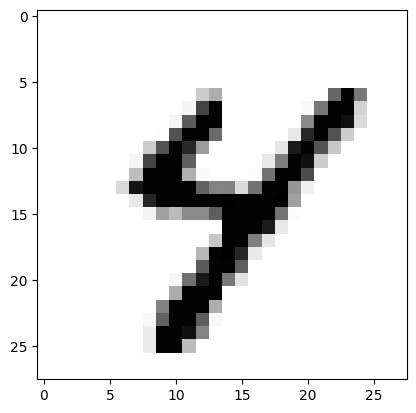

In [3]:
images, dense = next(iter(trainloader))
plt.imshow(images[0].permute(1, 2, 0), cmap="Greys")
images.shape, dense.shape

In [4]:
class DNN:
    def __init__(self, sizes=[784, 128, 64, 10], epochs=10, lr=0.001) -> None:
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr
        
        input_layer = sizes[0]
        hidden_1 = sizes[1]
        hidden_2 = sizes[2]
        output_layer = sizes[3]

        self.params = {
            "w1": torch.randn(input_layer, hidden_1),
            "w2": torch.randn(hidden_1, hidden_2),
            "w3": torch.randn(hidden_2, output_layer),
        }

    def sigmoid(self, z, derivative=False):
        if derivative:
            sig = self.sigmoid(z)
            return sig*(1-sig)
        return 1/(1+torch.exp(-z))
    
    def softmax(self, x:torch.Tensor, derivative=False):
        exps = torch.exp(x)
        if derivative:
            soft = self.softmax(x)
            return soft*(1-soft)
        return exps/exps.sum(axis=1).reshape(-1, 1)

    def forward_pass(self, x_train:torch.Tensor):
        params = self.params

        params['A0'] = x_train # MxN0

        # input layer to hidden_1
        params['Z1'] = params['A0']@params['w1'] # MxN0, N0xN1 => MxN1 
        params['A1'] = self.sigmoid(params['Z1']) # MxN1

        # hidden_1 to hidden_2
        params['Z2'] = params['A1']@params['w2'] # MxN1, N1xN2 => MxN2
        params['A2'] = self.sigmoid(params['Z2']) # MxN2

        # input layer to hidden_1
        params['Z3'] = params['A2']@params['w3'] # MxN2, N2xN3 => MxN3
        params['A3'] = self.softmax(params['Z3']) # MxN3

        return params['A3']


    def backward_pass(self, y_train, output):
        params = self.params

        gradients = {}

        # calculate w3 update
        CA3 = 2*(output-y_train) # MxN3

        A3Z3 = self.softmax(params['Z3'], derivative=True) # MxN3
        Z3W3 = params['A2']  # MxN2

        CZ3 = CA3 * A3Z3 # MxN3
        # CW3 = np.outer(Z3W3, CZ3) 
        CW3 = Z3W3[:, :, np.newaxis] * CZ3[:, np.newaxis, :] # MxN2x1, Mx1xN3 => MxN2xN3


        # calculate w2 update
        Z3A2 = params['w3'] # N2xN3
        CA2 = CZ3 @ Z3A2.T # MxN3, N3xN2 => MxN2

        A2Z2 = self.sigmoid(params['Z2'], derivative=True) # MxN2
        Z2W2 = params['A1'] # MxN1

        CZ2 = CA2 * A2Z2 # MxN2, MxN2 => MxN2
        # CW2 =  np.outer(Z2W2, CZ2)
        CW2 = Z2W2[:, :, np.newaxis] * CZ2[:, np.newaxis, :] # MxN1x1, Mx1xN2 => MxN2xN3

        # calculate w3 update
        Z2A1 = params['w2'] # N1xN2
        CA1 = CZ2 @ Z2A1.T # MxN2, N2xN1 => MxN1

        A1Z1 = self.sigmoid(params['Z1'], derivative=True) # MxN1
        Z1W1 = params['A0'] # MxN0

        CZ1 = CA1 * A1Z1 # MxN1, MxN1 => MxN1
        # CW1 =  np.outer(Z1W1, CZ1)
        CW1 = Z1W1[:, :, np.newaxis] * CZ1[:, np.newaxis, :] # MxN0x1, Mx1xN1 => MxN0xN1

        gradients['w3'] = CW3.sum(axis=0)
        gradients['w2'] = CW2.sum(axis=0)
        gradients['w1'] = CW1.sum(axis=0)

        return gradients
    
    def update_weights(self, gradients:dict):
        for weight, grad in gradients.items():
            self.params[weight] = self.params[weight] - self.lr*grad
                                    # N0xN1 - MxN0xN1

    def compute_accuracy(self, loader):
        data_length = 0
        true_preds = 0
        for data, targets in loader:
            outputs = self.forward_pass(data)
            
            data_length+=data.shape(0)
            true_preds += (torch.argmax(outputs, axis=1) == torch.argmax(targets, axis=1))

    def dense2sparse(self, dense, n_classes):
        sparse = torch.zeros((len(dense), n_classes))
        sparse[range(len(dense)), dense] = 1
        return sparse

    def train(self, trainloader):
        for e in range(self.epochs):
            data_length = 0
            true_preds = 0
            progress_bar = tqdm(trainloader, desc=f"Epoch {e+1}/{self.epochs}")
            for data, targets in progress_bar:
                data = data.flatten(start_dim=1)
                targets = self.dense2sparse(targets, self.sizes[-1])

                outputs = self.forward_pass(data)
                gradients = self.backward_pass(targets, outputs)
                self.update_weights(gradients)

                data_length+=data.shape[0]
                true_preds += (torch.argmax(outputs, axis=1) == torch.argmax(targets, axis=1)).sum()
                train_acc = (true_preds/data_length).item()
                progress_bar.set_postfix(train_acc=train_acc)

In [5]:
dnn = DNN()
dnn.train(trainloader)

Epoch 10/10: 100%|██████████| 60000/60000 [11:17<00:00, 88.50it/s, train_acc=0.792] 
